<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
#Import the dataset
path = '.../.../loan_train.csv'


In [3]:
df = pd.read_csv(path)

### Load Data From CSV File  

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

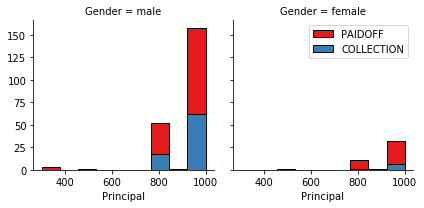

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

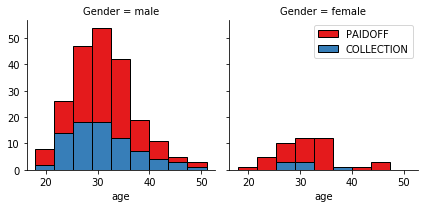

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

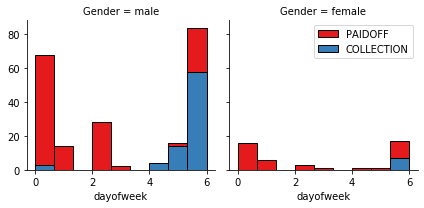

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split   #also for other methods (decision tree)
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [22]:
#split the data in a train and test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('The length of the train set is:', X_train.shape,  y_train.shape)
print ('The lenth of the test set equals:', X_test.shape,  y_test.shape)

The length of the train set is: (276, 8) (276,)
The lenth of the test set equals: (70, 8) (70,)


In [23]:
k = 15
neighbors = np.arange(1, 15) 
acc_list = np.empty(len(neighbors)) 

for k in range(1,k):
    neig = KNeighborsClassifier(n_neighbors=k)
    neig.fit(X_train, y_train) 
    y_pred = neig.predict(X_test)
    acc_list[k-1] = metrics.accuracy_score(y_test, y_pred)
    
acc_list

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       ])

Text(0, 0.5, 'Accuracy Score')

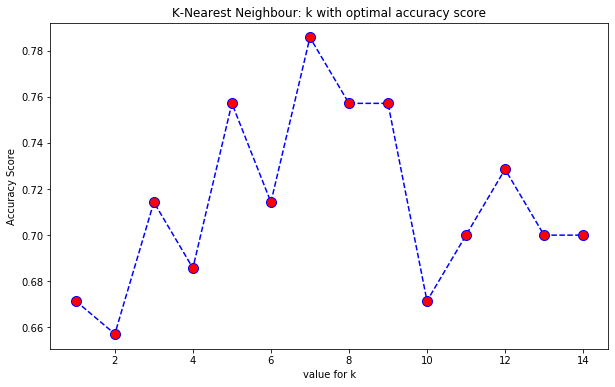

In [24]:
plt.figure(figsize=(10,6))
plt.plot(neighbors,acc_list,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)

plt.title("K-Nearest Neighbour: k with optimal accuracy score")
plt.xlabel("value for k")
plt.ylabel("Accuracy Score")

In [25]:
print("The optimal k equals 7.")

The optimal k equals 7.


In [26]:
#Train, estimate and predict the model with the best classifier where k equals 7:
neighborclass = KNeighborsClassifier(n_neighbors = 7)
knn_model = neighborclass.fit(X_train,y_train)
knn_ypred = knn_model.predict(X_test)

In [27]:
#Train data set: Accuracy Score Best Model where k equals 7:
accuracy_best_model = metrics.accuracy_score(y_test, knn_ypred)
accuracy_best_model 

0.7857142857142857

In [28]:
#Train data set: Jaccard Score Best Model where k equals 7:
from sklearn.metrics import jaccard_similarity_score

knn_jaccardscore = jaccard_similarity_score(y_test,knn_ypred)
knn_jaccardscore

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7857142857142857

In [29]:
#Train data set: F1-score where k equals 7:
from sklearn.metrics import f1_score

knn_fscore = f1_score(y_test, knn_ypred, average='weighted') 
knn_fscore


0.7766540244416351

# Decision Tree

In [30]:
#import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import jaccard_similarity_score


C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [31]:
# Run a for loop over the range of depth list length

n = 9
leaf = np.arange(1, 9) 
tree_list = np.empty(len(leaf)) 

for d in range(1,n):
    mytree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(X_train, y_train)
    y_pred = mytree.predict(X_test)
    tree_list[d-1] = metrics.accuracy_score(y_test,y_pred)
    
tree_list    

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286])

**A decision tree with a maximum dept of 2 would be optimal. So, let's develop the model.**

In [32]:
# Create Decision Tree classifer object with the maximum depth of 2 I calculated
clf = DecisionTreeClassifier(criterion="entropy", max_depth=2)

# Train Decision Tree Classifer
DT_Model = clf.fit(X_train,y_train)

#Predict the response for test dataset
ypred_tree = DT_Model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, ypred_tree))

Accuracy: 0.7857142857142857


In [33]:
#Jaccard score with decision tree classifier with maximum depth of 2
jacscore_tree = jaccard_similarity_score(y_test,ypred_tree)
jacscore_tree 

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7857142857142857

In [34]:
#F1 score with decision tree classifier with maximum depth of 2
fscore_tree = f1_score(y_test,ypred_tree, average='weighted') 
fscore_tree

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6914285714285714

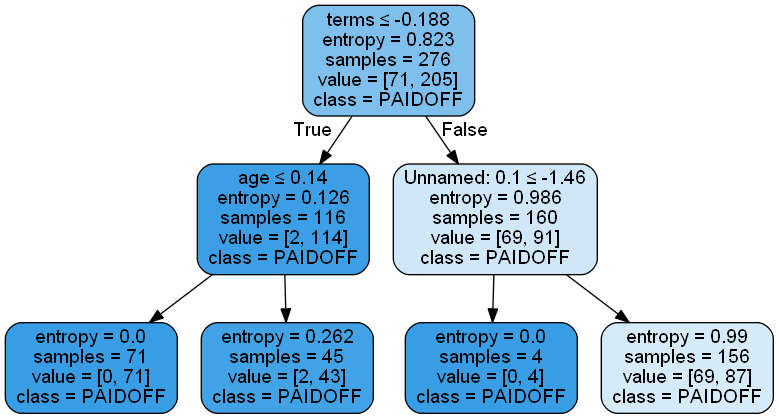

In [35]:
#entropy decision tree
dot_data = StringIO()
featureNames = df.columns[0:8]
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = featureNames,class_names=np.unique(y_train))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisiontree.png')
Image(graph.create_png())

# Support Vector Machine

In [36]:
from sklearn import svm
from sklearn.metrics import f1_score

In [37]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


**Best Model Selection: Accuracy with F-score**

In [38]:
kernel = ['rbf','linear','poly','sigmoid']   #recall kernel types from the video, which is the best type to use?
acc_score_list = []

for k in kernel:
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    acc_score_list.append(f1_score(y_test, ypred, average='weighted')) 
    
acc_score_list
    

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in ver

[0.7275882012724117,
 0.6914285714285714,
 0.7064793130366899,
 0.6892857142857144]

**The model with the best accuracy is the rbf model looking at the best accuracy F1-score. Let's develop a svm model with rbf.**

In [39]:
#Best model estimate including the F-score
svmmodel = svm.SVC(kernel='rbf')
svmmodel  = svmmodel.fit(X_train, y_train) 
svmmodel

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [40]:
svm_ypred = svmmodel.predict(X_test)
svm_score = f1_score(y_test, svm_ypred, average='weighted')
svm_score

0.7275882012724117

In [41]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


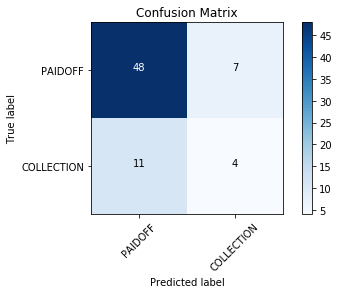

In [43]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svm_ypred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, svm_ypred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix')

In [44]:
#Jacquard Score
svm_jaccardscore = jaccard_similarity_score(y_test,svm_ypred)
svm_jaccardscore

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7428571428571429

# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [46]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


**Calculate the Model Accuracy for each Solver:**

The solvers for logistic regression include:<br>
- liblinear;
- saga;
- newton-cg;
- lbfgs;
- sag.

The model with the best solver will be determined based on the Log Loss probability.


**Based on the Log Loss:**

In [47]:
from sklearn.metrics import log_loss

In [48]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.5772287609479654

In [49]:
LR = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.49201776274077014

In [50]:
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.4920178014679269

In [51]:
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.4920179847937498

In [52]:
LR = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.4920039683693732

**Logistic Regression: Optimal Model**

The best model is the model with the liblinear solver.

In [53]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
lr_ypred = LR.predict_proba(X_test)
log_loss(y_test,lr_ypred)   #log loss

0.5772287609479654

In [55]:
#Jaccard score
yhat_lr = LR.predict(X_test)
lr_jaccard = jaccard_similarity_score(y_test,yhat_lr)
lr_jaccard

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.6857142857142857

In [56]:
#F1-score
lr_score = f1_score(y_test, yhat_lr, average='weighted')
lr_score

0.6670522459996144

# Model Evaluation using Test set

In [57]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [58]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

In [59]:
path_2 = '.../.../loan_test.csv'


### Load Test set for evaluation 

In [60]:
test_df = pd.read_csv(path_2)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


**Details:**

In [61]:
test_df.shape

(54, 10)

In [62]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [63]:
test_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

**Data preparation and cleaning for calculating the accuracy scores:**

In [64]:
#convert the due date and the effective date to a datetime variable
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [65]:
#add the day of week as in the train data frame above
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#add the weekend variable as in the train data frame above
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [66]:
#Normalizing the data
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)


education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [67]:
#categorical to binary variables
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


**Set the Variables for the Machine Learning Metrics:**

In [68]:
Feature_test_set = Feature
X_test_set = Feature_test_set

In [69]:
X_test_set= preprocessing.StandardScaler().fit(X_test_set).transform(X_test_set)

In [70]:
y_test_set = test_df['loan_status'].values

**Calculate the Scores:**

**KNN:**

In [71]:
#jaccard score
ypred_KNN = knn_model.predict(X_test_set)
KNN_Jac_Score = jaccard_similarity_score(y_test_set,ypred_KNN)
KNN_Jac_Score

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.6666666666666666

In [72]:
#F1-score
KNN_fscore = f1_score(y_test_set, ypred_KNN, average='weighted')
KNN_fscore 

0.6328400281888654

**Decision Tree:**

In [73]:
#jaccard score
ypred_DT = DT_Model.predict(X_test_set)
DT_Jac_Score = jaccard_similarity_score(y_test_set,ypred_DT)
DT_Jac_Score

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7407407407407407

In [74]:
#F1-score
DT_fscore = f1_score(y_test_set, ypred_DT, average='weighted')
DT_fscore

C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6304176516942475

**SVM:**

In [75]:
#jaccard score
ypred_svm = svmmodel.predict(X_test_set)
svm_Jac_Score = jaccard_similarity_score(y_test_set,ypred_svm)
svm_Jac_Score


C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7962962962962963

In [76]:
#F1-score
svm_fscore = f1_score(y_test_set, ypred_svm, average='weighted')
svm_fscore


0.7583503077293734

**Logistic Regression:**

In [77]:
#jaccard score
ypred_lr = LR.predict(X_test_set)
lr_Jac_Score = jaccard_similarity_score(y_test_set,ypred_lr)
lr_Jac_Score


C:\Users\Lydia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.7407407407407407

In [78]:
#F1-score
lr_fscore = f1_score(y_test_set, ypred_lr, average='weighted')
lr_fscore


0.6604267310789049

In [79]:
#Log Loss
lr_ypred_test = LR.predict_proba(X_test_set)
log_loss(y_test_set,lr_ypred_test)   #log loss


0.5672153379912981

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67     | 0.63      | NA      |
| Decision Tree      | 0.74      | 0.63       | NA      |
| SVM                | 0.80      | 0.76        | NA      |
| LogisticRegression | 0.74      | 0.66     | 0.57       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>